<a href="https://colab.research.google.com/github/rklepov/hse-cs-ml-2018-2019/blob/homework/05-NN/HW/hw5/nn_hw5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> ### *NN HW5*


```
ДЗ - https://keras.io/examples/cifar10_cnn/ данную сеть можно взять как исходную. В ней необходимо заменить аугментации на albumentations и подобрать их правильно. Саму структуру сети тоже можно менять - точность ожидается не менее 90
```

In [0]:
# !pip install tf-nightly-2.0-preview
# !pip install git+https://github.com/tensorflow/probability.git --upgrade

In [0]:
import os
import numpy as np
from matplotlib.pylab import plt
%matplotlib inline

In [3]:
import tensorflow_probability as tfp
import tensorflow as tf

import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



Using TensorFlow backend.


In [4]:
tf.__version__

'1.13.1'

In [0]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose, NoOp
)

> ## CIFAR10

https://keras.io/examples/cifar10_cnn/

In [6]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (50000, 32, 32, 3)
X_test shape: (10000, 32, 32, 3)


In [7]:
num_classes = len(np.unique(y_train, axis=0))

num_classes

10

Для валидации будем использовать часть обучающего датасета. Удобнее разбить и перемешать сеты заранее.

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, stratify=y_train)

In [9]:
X_train_scaled, X_val_scaled, X_test_scaled = [ X.astype('float32')/255 for X in (X_train, X_val, X_test) ]

y_train, y_val, y_test = [ keras.utils.to_categorical(y, num_classes) for y in (y_train, y_val, y_test) ]

y_train[:5]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

> ## Аугментация

Аугментацию изображений будем делать с помощью библиотеки [albumenations](https://github.com/albu/albumentations) (ниже функция из [примера](https://albumentations.readthedocs.io/en/latest/examples.html)).

In [0]:
def strong_aug(p=0.5):
    return Compose([
        RandomRotate90(),
        Flip(),
        Transpose(),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.2),
        OneOf([
            MotionBlur(p=0.2),
            MedianBlur(blur_limit=3, p=0.1),
            Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=0.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(),
            IAAEmboss(),
            RandomBrightnessContrast(),
        ], p=0.3),
        HueSaturationValue(p=0.3),
    ], p=p)

Пример аугментации:

In [0]:
def plot_augs(image, aug, n):
    fig, ax = plt.subplots(1, n, sharey='row', figsize=(16, 10))
    xticks = np.arange(0, image.shape[0]+1, image.shape[0] // 3)
    ax[0].imshow(image)
    ax[0].set_xticks(xticks)
    for i in range(1, n):
        ax[i].set_xticks(xticks)
        ax[i].imshow(aug(image=image)['image'])

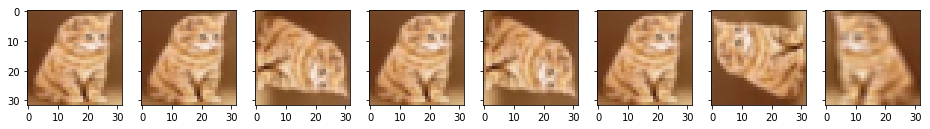

In [12]:
plot_augs(X_train[99], strong_aug(.9), 8);

> ## Модель без аугментации


In [0]:
BATCH_SIZE = 50
N_EPOCH = 100

In [0]:
def make_model(input_shape=X_train.shape[1:], num_classes=num_classes):
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))
    
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    # initiate RMSprop optimizer
    opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model

In [15]:
model_direct = make_model()

model_direct.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)  

In [0]:
hist_direct = model_direct.fit(X_train_scaled, y_train,
                               batch_size=BATCH_SIZE,
                               epochs=N_EPOCH,
                               shuffle=False,                               
                               validation_data=(X_val_scaled, y_val),
                               callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

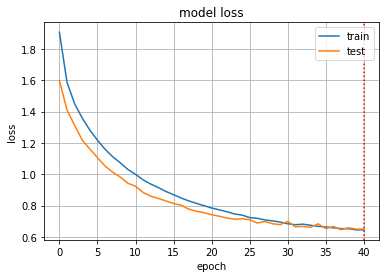

In [17]:
def plot_history(hist):
    plt.plot(hist['loss'])
    plt.plot(hist['val_loss'])
    plt.axvline(x=len(hist['loss'])-1, color='r', linestyle=':')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.xticks(np.arange(0, len(hist['loss']) + 1, 5))
    plt.legend(['train', 'test'], loc='upper right')
    plt.grid()

plot_history(hist_direct.history);

In [18]:
scores = model_direct.evaluate(X_test_scaled, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 1s 79us/step
Test loss: 0.6749558330535889
Test accuracy: 0.7689


In [19]:
y_pred = model_direct.predict(X_test_scaled, verbose=1)

10000/10000 [==============================] - 1s 76us/step


In [20]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.85      0.76      0.81      1000
           1       0.92      0.83      0.87      1000
           2       0.72      0.61      0.66      1000
           3       0.66      0.51      0.58      1000
           4       0.67      0.79      0.72      1000
           5       0.66      0.69      0.68      1000
           6       0.73      0.89      0.81      1000
           7       0.82      0.82      0.82      1000
           8       0.84      0.90      0.87      1000
           9       0.83      0.88      0.85      1000

   micro avg       0.77      0.77      0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



> ## Модель с аугментацией

Идея генератора взята из статьи [How to increase your small image dataset using Keras ImageDataGenerator](https://medium.com/@arindambaidya168/https-medium-com-arindambaidya168-using-keras-imagedatagenerator-b94a87cdefad).

***TODO***: унаследовать генератор от [`keras.utils.Sequence`](https://keras.io/utils/#sequence)  чтобы [иметь возможность](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly)  использовать `workers > 1` для [`keras.model.fit_generator`](https://keras.io/models/model/#fit_generator).

In [0]:
def aug_generator(X, y, aug, batch_size=BATCH_SIZE):
    while True:
        # randomize the indices to make an array
        ix = np.random.permutation(X.shape[0])
        for batch in range(0, len(X), batch_size):
            # slice out the current batch according to batch-size
            current_batch = ix[batch:(batch + batch_size)]
            
            X_aug = np.empty([0]+list(X.shape[1:]), dtype=np.int)
            
            for i in current_batch:
                image = aug(image=X[i])['image']
                X_aug = np.append(X_aug, [image], axis=0)

            yield (X_aug.astype('float32')/255, y[current_batch])

Я думаю, что из-за низкого разрешения изображений, какие-то сложные аугментации в данном случае, скорее всего, смысла делать нет. Попробуем ограничиться поворотами и отображениями.

[`steps_per_epoch`](https://keras.io/models/model/#fit_generator): [How to use Keras fit and fit_generator (a hands-on tutorial)
](https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/)

In [0]:
model_aug = make_model()

hist_aug = model_aug.fit_generator(aug_generator(X_train, y_train, batch_size=BATCH_SIZE,
                                                 aug=Compose([OneOf([Flip(p=1.), RandomRotate90(p=1.), Transpose(p=1.), HorizontalFlip(p=1.)], p=.5),
                                                              ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=.5),
                                                              CLAHE(clip_limit=2, p=.2)], p=.4)),
                                   epochs=N_EPOCH,
                                   steps_per_epoch=len(X_train) // BATCH_SIZE,
                                   validation_data=aug_generator(X_val, y_val, batch_size=BATCH_SIZE, aug=NoOp()),
                                   validation_steps=len(X_val) // BATCH_SIZE,
                                   callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
                                   workers=1)

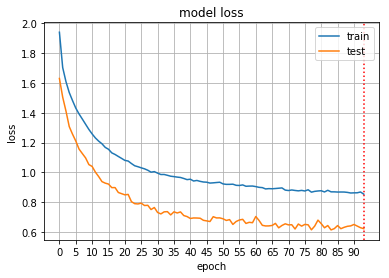

In [23]:
plot_history(hist_aug.history);

In [24]:
scores = model_aug.evaluate(X_test_scaled, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 1s 76us/step
Test loss: 0.6390180183410644
Test accuracy: 0.7876


In [25]:
y_pred = model_aug.predict(X_test_scaled, verbose=1)

10000/10000 [==============================] - 1s 77us/step


In [26]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1000
           1       0.92      0.84      0.88      1000
           2       0.82      0.57      0.67      1000
           3       0.66      0.62      0.64      1000
           4       0.70      0.82      0.75      1000
           5       0.75      0.67      0.71      1000
           6       0.79      0.87      0.83      1000
           7       0.82      0.84      0.83      1000
           8       0.83      0.91      0.87      1000
           9       0.82      0.91      0.86      1000

   micro avg       0.79      0.79      0.79     10000
   macro avg       0.79      0.79      0.78     10000
weighted avg       0.79      0.79      0.78     10000



> ## Вывод

Аугментация позволила немного улучшить качество модели, хотя требуемой точности достигнуть не удалось. Возможно, необходимо усложнить модель и/или попробовать более сложные аугментации (но, как первое, так и второе делать не хотелось бы, потому что и так учится довольно долго).